## Policy-Gradient
In this notebook we train a policy gradient agent on CartPole and convert it to a spiking network. We train the agent using a script, because our train agent function only supports training DQNs.
<div class="alert alert-block alert-info">
<b>Info:</b> The agent we train is not the same due to different seeds, but the agent used in the thesis is saved in Results/CartPole-PolicyGradient.
</div>
<div class="alert alert-block alert-warning">
<b>Attention:</b> If the result directory with the specified name already exists, this will throw an error. You need to specify a different name or delete the old directory. If this happens, you should restart the kernel, as the directory is a relative path which changes everytime this cell is run.
</div>

In [2]:
# adapted from the tutorial from https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf

%matplotlib inline
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
from itertools import count
import matplotlib.pyplot as plt
import os
import sys

# hack to perform relative imports
sys.path.append('../../')
from Code import plot_durations, save_model
# device: automatically runs on GPU, if a GPU is detected, else uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Detected PyNN version 0.9.5 and Neo version 0.6.1


In [3]:
# set up result directory
name = 'CartPole-Experiment-PolicyGradient'
result_directory = './../../Results/' + str(name)
os.makedirs(result_directory)
os.chdir(result_directory)

In [4]:
# choose environment
env = gym.make('CartPole-v0')
# set seeds
env.seed(1); torch.manual_seed(1)

#Hyperparameters
learning_rate = 0.01
gamma = 0.99
max_steps = 200

In [5]:
# Neural network for Policy
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # hardcoded for CartPole
        self.state_space = 4
        self.action_space = 2

        self.l1 = nn.Linear(self.state_space, 16, bias=True)
        self.l2 = nn.Linear(16, 16, bias=True)
        self.l3 = nn.Linear(16, self.action_space, bias=True)

        self.gamma = gamma

        # Episode policy and reward history
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
    
    def forward_return_all(self,x):
        all_outputs = []
        x = F.relu(self.l1(x))
        all_outputs.append(x)
        x = F.relu(self.l2(x))
        all_outputs.append(x)
        x = self.l3(x)
        all_outputs.append(x)
        return all_outputs

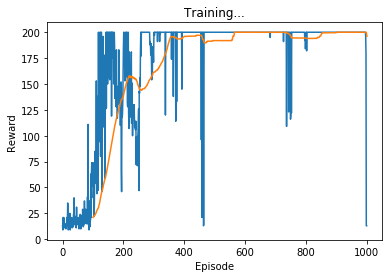

OpenAIGymStandard reached after 659 iterations
Best average:  200
Complete


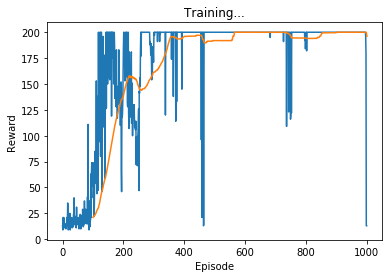

In [1]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)


def select_action(state):
    # Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = F.softmax(policy(torch.tensor(state,dtype=torch.float,requires_grad=True)))
    c = Categorical(state)
    action = c.sample()
    return action


def update_policy(state_history,policy_history):
    R = 0
    rewards = []

    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0, R)
    # Scale rewards
    rewards = torch.tensor(rewards,dtype=torch.float)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    predictions = policy(torch.tensor(state_history,dtype=torch.float,requires_grad=True))

    # Calculate loss
    loss = []
    for t in range(0,rewards.shape[0]):
        element_loss = torch.nn.functional.log_softmax(predictions[t])[policy_history[t]]
        element_loss = torch.mul(element_loss,rewards[t])
        loss.append(element_loss)
    # negative mean, because we do gradient ascent
    loss = -sum(loss)/len(loss)

    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = torch.tensor([])
    policy.reward_episode = []

episode_durations = []
def main(episodes):
    # save initial model
    save_model(policy, 'initial')
    best_average = 0
    avg_counter = 0
    finished=False
    finished_after = np.inf
    for episode in range(episodes):
        state_history = []
        policy_history = []
        env._max_episode_steps = max_steps
        state = env.reset()  # Reset environment and record the starting state
        done = False

        for t in count():
            state_history.append(state)
            env.render()
            action = select_action(state)
            policy_history.append(action)
            # Step through environment using chosen action
            state, reward, done, _ = env.step(action.item())

            # Save reward
            policy.reward_episode.append(reward)
            if done:
                # save neural network if open ai gym standard is reached:
                durations_t = torch.tensor(episode_durations, dtype=torch.float)
                if len(durations_t) >= 100:
                    average = durations_t[durations_t.shape[0] - 100:durations_t.shape[0]].mean()
                    if average > best_average:
                        best_average = average
                    if average >= 195:
                        avg_counter += 1
                    else:
                        avg_counter = 0
                    if avg_counter >= 100 and not finished:
                        save_model(policy, 'trained')
                        # break the training loop
                        finished = True
                        finished_after = episode
                if t+1 > best_average:
                    best_average = t+1
                # plot rewards/durations
                episode_durations.append(t + 1)
                plot_durations(episode_durations)
                break
        update_policy(state_history,policy_history)
    if finished:
        print('OpenAIGymStandard reached after',finished_after,'iterations')
    else:
        print('Failed to reach OpenAIGymStandard')
    print('Best average: ', best_average)
    print('Complete')
    env.close()
    plt.ioff()
    plt.show()


episodes = 1000
main(episodes)


In the plot, blue shows individual episode performances and orange shows 100-episode average performances. 

Next, we load the agent to save its replay memory.

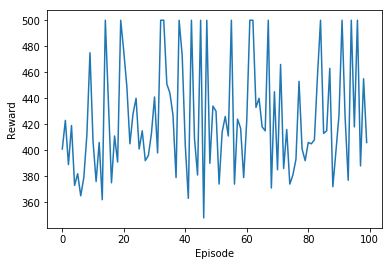

Complete
Mean:  424.15
Std:  42.540384852917626


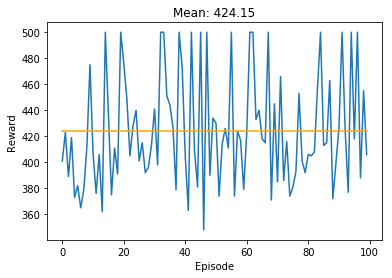

In [7]:
from Code import load_agent
env = 'CartPole-v0'
# load the policy gradient network used in the thesis
os.chdir('./../CartPole-PolicyGradient')
architecture = [4, 16, 16, 2]
policy_net = Policy().to(device)
# Alternatively, you can also load the policy gradient network used in our thesis saved in the result directory
policy_net.load_state_dict(torch.load('trained/model.pt'))
# for a tutorial of load, see CartPole-Experiment2
load_agent(env,policy_net,device,save_replay=True,max_steps=500)


One can see that PolicyGradient generalizes much better than a DQN for CartPole and leads to consistently achieving rewards close to or at the maximum of 500.

Next, we convert the PolicyGradient network to a spiking network.

In [8]:
# for a tutorial of converting, see CartPole-Experiment4
from Code import weight_conversion, SQN
# load the network, take care that you choose the same architecture and class as the model that is loaded
path_to_network = './trained/model.pt'
architecture = [4, 16, 16, 2]
policy_net = Policy().to(device)
policy_net.load_state_dict(torch.load(path_to_network))

# choose the conversion method ('robust','model', or 'data')
CONVERSION_METHOD = 'robust' 
# for robust we additionally need to specify the path to the replay and the ppercentile
path_to_replay = './trained' # needed for data-based and robust
ppercentile = 0.99

# for the conversion the weights and biases need to be provided in the form [W1,W2,..,Wn] and [b1,b2,...,bn]
weights = []
biases = []
weights.append(policy_net.l1.weight.data)
biases.append(policy_net.l1.bias.data)
weights.append(policy_net.l2.weight.data)
biases.append(policy_net.l2.bias.data)
weights.append(policy_net.l3.weight.data)
biases.append(policy_net.l3.bias.data)

# call the weight conversion method provided in the SQN module
converted_weights, converted_biases = weight_conversion(policy_net,weights,biases,device, 
                                                        normalization_method=CONVERSION_METHOD,
                                                        ppercentile=ppercentile,path_to_replay=path_to_replay)

In [10]:
# save the weights of the converted network
# set up the spiking network
architecture = [4,16,16,2]
converted = SQN(architecture,device,alpha=0.0,beta=1.0,simulation_time=100,add_bias_as_observation=False,
                  encoding='constant',decoding='potential',reset='subtraction',threshold=1.0)
# load the converted weights
converted.load(converted_weights,converted_biases)
# save the network
save_model(converted,'converted')

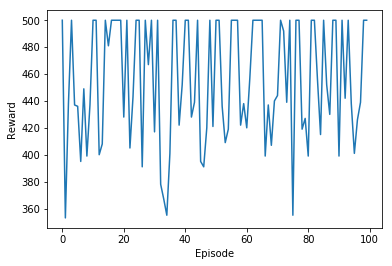

Similarity (Conversion Accuracy) after 45510 iterations: 89.52977367611514%
Complete
Mean:  455.1
Std:  44.770683950707536
Similarity (Conversion Accuracy) after 45510 iterations: 89.52977367611514%


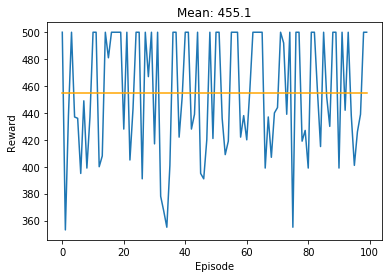

In [8]:
from Code import load_agent
env = 'CartPole-v0'
# load the agent and compare with the original Policy Gradient agent
load_agent(env,converted,device,epsilon=0,gym_seed=1,save_replay=False,
           max_steps=500,num_episodes=100, render=True, compare_against=policy_net)

It can be seen that direct conversion of a Policy Gradient network results in a very similar network compared to the original one.